Adapted from: 
    
- https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/

- https://github.com/spdin/time-series-prediction-lstm-pytorch/blob/master/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb

and my colleague Scott Pitz from Insight: 
- https://github.com/slpitz/RNNandGHGs/blob/master/RNN_MaunaLoa_data.ipynb


In [345]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler


In [346]:
#myfile = 'ftp://aftp.cmdl.noaa.gov/data/trace_gases/co2/flask/surface/co2_mlo_surface-flask_1_ccgg_month.txt'
# myfile2019 = 'ftp://aftp.cmdl.noaa.gov/data/trace_gases/co2/in-situ/surface/mlo/co2_mlo_surface-insitu_1_ccgg_MonthlyData.txt'

myfile2019 = 'co2_mlo_surface-insitu_1_ccgg_MonthlyData.txt'
# making data frame   
#df = pd.read_csv(myfile,sep='\t',skiprows=(0,1,2),header=(70))
#df = pd.read_csv(myfile,sep='\r',header=(69), delim_whitespace=True)
#df = pd.read_csv(myfile2019, header= (150), delim_whitespace=True)
df = pd.read_csv(myfile2019, header= (149), delim_whitespace=True)
    
# "uncertain" values in MLO are filled in with "-999" 
df = df[df['value']>-100]    
    
df.head()


,site_code,year,month,day,hour,minute,second,time_decimal,value,value_std_dev,nvalue,latitude,longitude,altitude,elevation,intake_height,qcflag
16,MLO,1974,5,1,0,0,0,1974.328767,333.16,0.34,14,19.536,-155.576,3437.0,3397.0,40.0,...
17,MLO,1974,6,1,0,0,0,1974.413699,332.11,0.46,26,19.536,-155.576,3437.0,3397.0,40.0,...
18,MLO,1974,7,1,0,0,0,1974.495890,331.11,0.49,24,19.536,-155.576,3437.0,3397.0,40.0,...
19,MLO,1974,8,1,0,0,0,1974.580822,329.09,0.64,27,19.536,-155.576,3437.0,3397.0,40.0,...
20,MLO,1974,9,1,0,0,0,1974.665753,327.27,0.63,24,19.536,-155.576,3437.0,3397.0,40.0,...


In [347]:

# df = pd.read_csv('co2_mlo_surface-flask_1_ccgg_event.txt', skiprows=69,  delim_whitespace=True)
# print(df.info())
# df.head()


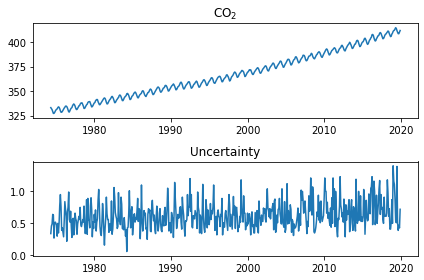

In [348]:
# training_set = pd.read_csv('airline-passengers.csv')
# #training_set = pd.read_csv('shampoo.csv')

# training_set = training_set.iloc[:,1:2].values

# plt.plot(training_set, label = 'Shampoo Sales Data')
# plt.show()


plt.subplot(211)
plt.plot(df['time_decimal'], df['value'])
plt.title('CO$_2$')

plt.subplot(212)
plt.plot(df['time_decimal'], df['value_std_dev'])
plt.title('Uncertainty')
plt.tight_layout()


In [349]:

distance = df['time_decimal'].diff()

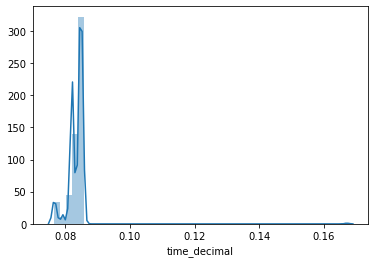

In [350]:
sns.distplot(distance)


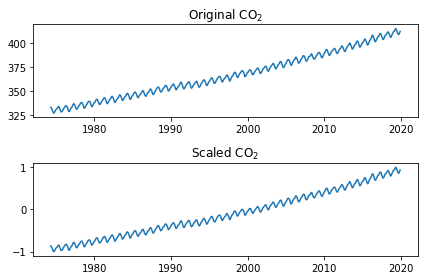

In [351]:
plt.subplot(211)
plt.plot(df['time_decimal'], df['value'])
plt.title('Original CO$_2$')

scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(df['value'].values.reshape(-1, 1))

plt.subplot(212)
plt.plot(df['time_decimal'], scaled_data)
plt.title('Scaled CO$_2$')

plt.tight_layout()


In [352]:
def sliding_windows(data, seq_length):
    x = []
    y = []
    n_elems = len(data)

    # Train on n=seq_length data points, predict the seq_length+1 data point
    for i in range(n_elems-seq_length-1):
        x.append(data[i:(i+seq_length)])
        y.append(data[i+seq_length])

    return np.array(x),np.array(y)

training_data = df['value'].values

seq_length = 6  #This variable is used later in LSTM

x, y = sliding_windows(scaled_data, seq_length)

In [353]:
n_elems = len(x)

train_set_size = int(n_elems * 0.8)

In [354]:
train_set_size

432

In [355]:
X_train = Variable(torch.tensor(np.array(x[0:train_set_size])))#.double()
y_train = Variable(torch.tensor(np.array(y[0:train_set_size])))#.double()

X_test = Variable(torch.tensor(np.array(x[train_set_size:])))#.double()
y_test = Variable(torch.tensor(np.array(y[train_set_size:])))#.double()

In [356]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

y_train = y_train.reshape(y_train.shape[0],1)
y_test = y_test.reshape(y_test.shape[0],1)

In [357]:
X_train.dtype

torch.float64

In [358]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out


In [359]:
num_epochs = 2000
learning_rate = 0.0001

input_size = 1
hidden_size = 24
num_layers = 1

num_classes = 1
history = []

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(X_train.float())
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, y_train.float())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
        history.append([epoch, loss.item()])
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


Epoch: 0, loss: 0.21598
Epoch: 100, loss: 0.17941
Epoch: 200, loss: 0.14602
Epoch: 300, loss: 0.11161
Epoch: 400, loss: 0.07996
Epoch: 500, loss: 0.04703
Epoch: 600, loss: 0.02129
Epoch: 700, loss: 0.01063
Epoch: 800, loss: 0.00807
Epoch: 900, loss: 0.00701
Epoch: 1000, loss: 0.00628
Epoch: 1100, loss: 0.00578
Epoch: 1200, loss: 0.00544
Epoch: 1300, loss: 0.00523
Epoch: 1400, loss: 0.00509
Epoch: 1500, loss: 0.00501
Epoch: 1600, loss: 0.00494
Epoch: 1700, loss: 0.00489
Epoch: 1800, loss: 0.00484
Epoch: 1900, loss: 0.00480


Text(0, 0.5, 'loss function')

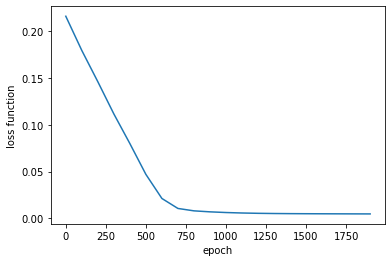

In [360]:
epoch =[z[0] for z in history]
loss = [z[1] for z in history]
plt.plot(epoch,loss)
plt.xlabel('epoch')
plt.ylabel('loss function')

In [361]:
lstm.eval()


LSTM(
  (lstm): LSTM(1, 24, batch_first=True)
  (fc): Linear(in_features=24, out_features=1, bias=True)
)

In [362]:
y_pred = lstm(X_test.float())


In [363]:
y_pred = scaler.inverse_transform(y_pred.data.numpy())

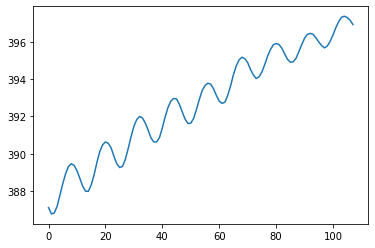

In [364]:
plt.plot(y_pred)

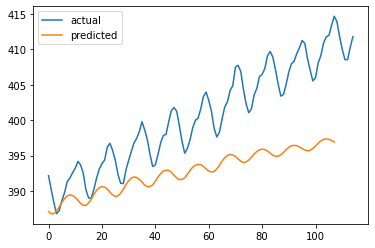

In [365]:
plt.plot(scaler.inverse_transform(scaled_data[train_set_size:]), label='actual')
plt.plot(y_pred, label='predicted')
plt.legend()

In [ ]:
# lstm.eval()
# train_predict = lstm(X_test)

# data_predict = train_predict.data.numpy()
# dataY_plot = dataY.data.numpy()

# data_predict = sc.inverse_transform(data_predict)
# dataY_plot = sc.inverse_transform(dataY_plot)

# plt.axvline(x=train_size, c='r', linestyle='--')

# plt.plot(dataY_plot)
# plt.plot(data_predict)
# plt.suptitle('Time-Series Prediction')
# plt.show()


In [237]:
# class LSTM(nn.Module):
#     def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
#         super().__init__()
#         self.hidden_layer_size = hidden_layer_size

#         self.lstm = nn.LSTM(input_size, hidden_layer_size)

#         self.linear = nn.Linear(hidden_layer_size, output_size)

#         self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
#                             torch.zeros(1,1,self.hidden_layer_size))

#     def forward(self, input_seq):
#         lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
#         predictions = self.linear(lstm_out.view(len(input_seq), -1))
#         return predictions[-1]


In [238]:
# model = LSTM()
# loss_function = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [198]:
X_train.shape[0]

432

In [275]:
# epochs = 150

# for i in range(epochs):
#     for seq in X_train:
#         optimizer.zero_grad()
#         model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
#                         torch.zeros(1, 1, model.hidden_layer_size))

#         y_pred = model(seq.double())

#         single_loss = loss_function(y_pred)
#         single_loss.backward()
#         optimizer.step()

#     if i%25 == 1:
#         print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

# print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')


In [240]:
# class LSTM(nn.Module):

#     def __init__(self, num_classes, input_size, hidden_size, num_layers):
#         super(LSTM, self).__init__()
        
#         self.num_classes = num_classes
#         self.num_layers = num_layers
#         self.input_size = input_size
#         self.hidden_size = hidden_size
#         self.seq_length = seq_length
        
#         self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
#                             num_layers=num_layers, batch_first=True)
        
#         self.fc = nn.Linear(hidden_size, num_classes)

#     def forward(self, x):
#         h_0 = Variable(torch.zeros(
#             self.num_layers, x.size(0), self.hidden_size))
        
#         c_0 = Variable(torch.zeros(
#             self.num_layers, x.size(0), self.hidden_size))
        
#         # Propagate input through LSTM
#         ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
#         h_out = h_out.view(-1, self.hidden_size)
        
#         out = self.fc(h_out)
        
#         return out


In [276]:
# num_epochs = 2000
# learning_rate = 0.01

# input_size = 1
# hidden_size = 2
# num_layers = 1

# num_classes = 1

# lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

# criterion = torch.nn.MSELoss()    # mean-squared error for regression
# optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# # Train the model
# for epoch in range(num_epochs):
#     outputs = lstm(X_train)
#     optimizer.zero_grad()
    
#     # obtain the loss function
#     loss = criterion(outputs, Y_train)
    
#     loss.backward()
    
#     optimizer.step()
#     if epoch % 100 == 0:
#       print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
